In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from stratx import featimp
from stratx.partdep import *
from rfpimp import plot_importances
import rfpimp

import shap

%config InlineBackend.figure_formats = ['svg','png']

In [123]:
def synthetic_poly_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    #TODO add noise
    terms = [f"{coeff[i]:.1f}x_{i+1}" for i in range(p)]
    eqn = "y = " + '+'.join(terms)
    return df, coeff, eqn

In [124]:
def synthetic_poly2_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, -3, 3])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] - 3*df['x2'] + 3*df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 - 3 x_2 + 3 x_3^2"

In [125]:
def shap_importances(rf, X):
    shap_values = shap.TreeExplainer(rf).shap_values(X)
    shapimp = np.mean(np.abs(shap_values), axis=0)
    print(shapimp)
    shapI = pd.DataFrame(data={'Feature': X.columns, 'Importance': shapimp})
    shapI = shapI.set_index('Feature')
    shapI = shapI.sort_values('Importance', ascending=False)
    #plot_importances(shapI)
    return shapI

In [126]:
def ginidrop_importances(rf, X):
    ginidrop_I = rf.feature_importances_
    ginidrop_I = pd.DataFrame(data={'Feature': X.columns, 'Importance': ginidrop_I})
    ginidrop_I = ginidrop_I.set_index('Feature')
    ginidrop_I = ginidrop_I.sort_values('Importance', ascending=False)
    return ginidrop_I

In [127]:
def compare_imp(rf,X,y,eqn):
    fig, axes = plt.subplots(1,5,figsize=(10,2))

    I, _, _ = featimp.importances(X, y)
    plot_importances(I, imp_range=(0,1),ax=axes[0])
    
    shap_I = shap_importances(rf, X)
    plot_importances(shap_I,ax=axes[1])

    gini_I = ginidrop_importances(rf, X)
    plot_importances(gini_I,ax=axes[2])

    perm_I = rfpimp.importances(rf,X,y)
    plot_importances(perm_I,ax=axes[3])
    drop_I = rfpimp.dropcol_importances(rf,X,y)
    plot_importances(drop_I,ax=axes[4])

    axes[0].set_title("Strat Imp")
    axes[1].set_title("SHAP Imp")
    axes[2].set_title("ginidrop Imp")
    axes[3].set_title("Permute column")
    axes[4].set_title("Drop column")
    plt.suptitle(f"${eqn}$")
    fig.tight_layout()
    fig.subplots_adjust(top=.7)

In [128]:
palette = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
    "#ffff99", 
    "#b15928"
]
def plot_all_PD(X,y,eqn=None,min_samples_leaf=5):
    fig, ax = plt.subplots(1,1)
    for i,colname in enumerate(X.columns):
        plot_stratpd(X, y, colname, 'y', ax=ax, min_samples_leaf=min_samples_leaf,
                     show_slope_lines=False,
                     pdp_marker_color=palette[i])
#     uniq_x = np.array(sorted(np.unique(X[:,0])))
#     ax2 = ax.twinx()
    record_x = range(len(y))
    record_x = (record_x - np.mean(record_x)) / np.std(record_x)
    ax.plot(record_x, y, lw=.3, c='k', label='marginal $y$ vs $x^{(i)}$')
    if eqn is not None:
        plt.title(f"${eqn}$")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Synthetic degree 1 polynomial

In [129]:
df, coeff, eqn = synthetic_poly_data(500,3)
df.head()

,x1,x2,x3,y
0,2.6,8.8,1.1,72.975672
1,9.4,3.1,7.9,76.137902
2,9.5,1.3,3.4,42.228610
3,0.7,0.9,6.8,39.689354
4,9.4,5.3,7.3,89.109781


In [130]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)

rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

x1 mass 7.933804974906191
min,max pdpy 0.0 17.059352492894593
x2 mass 35.58576813879408
min,max pdpy -1.0189060304963964 68.77760703422206
x3 mass 22.295135870500804
min,max pdpy -2.926176170997735 40.741713362109245
Avgs [ 7.93380497 35.58576814 22.29513587] sum avgs 65.81470898420108
### remaining mass % -6.632371210378926
normalized avgs [0.12854276 0.57655726 0.36122369] ratios 0.22294881886382822
mean abs y 66.64003359271936
y_mass = mean abs min-clipped 61.72113424576559
mean abs mean-centered 20.78686069932517
[ 3.04075592 18.27099608 11.62725216]


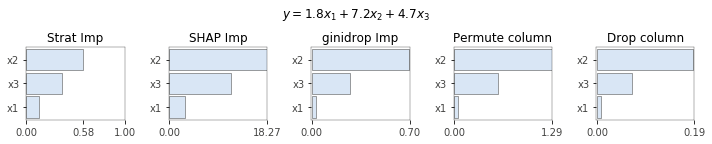

In [131]:
compare_imp(rf,X,y,eqn)

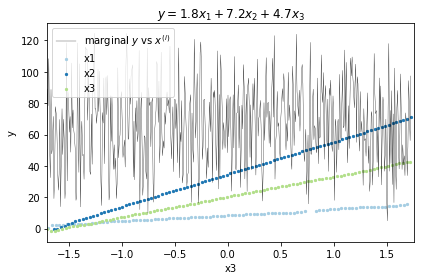

In [132]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial

In [133]:
df, coeff, eqn = synthetic_poly2_data(500,3)
df.head()

,x1,x2,x3,y
0,7.4,1.7,6.5,158.65
1,7.6,9.9,6.5,135.05
2,7.6,4.1,8.6,247.58
3,5.1,1.9,0.0,19.80
4,2.3,1.6,4.9,78.73


In [134]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

x1 mass 23.73443000325343
min,max pdpy 0.0 49.827683550298595
x2 mass 12.93787764774068
min,max pdpy -21.37252898919802 1.080432257306571
x3 mass 98.9070108197242
min,max pdpy 0.0 287.16694255543734
Avgs [23.73443    12.93787765 98.90701082] sum avgs 135.5793184707183
### remaining mass % -2.601401669266392
normalized avgs [0.17961337 0.09790906 0.74849159] ratios 1.834491765146514
mean abs y 114.65673999999999
y_mass = mean abs min-clipped 132.14177999999998
mean abs mean-centered 82.36391632000003
[10.93647249  5.12318749 81.46302441]


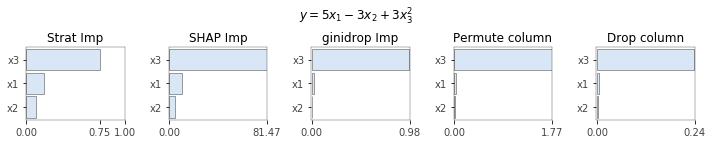

In [135]:
compare_imp(rf,X,y,eqn)

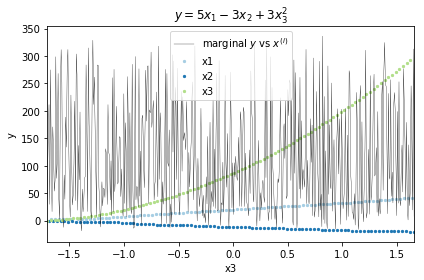

In [136]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial with duplicated column x_3

In [137]:
def synthetic_poly2dup_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, 3, 9])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    df['x3'] = df['x1']  # copy x1 into x3
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] + 3*df['x2'] + 9*df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 + 3 x_2 + 9*x_3^2 where x_3 = x_1"

In [138]:
df, coeff, eqn = synthetic_poly2dup_data(500,3)
df.head()

,x1,x2,x3,y
0,0.6,6.7,0.6,26.34
1,6.9,6.9,6.9,483.69
2,3.3,5.9,3.3,132.21
3,2.9,4.2,2.9,102.79
4,6.3,6.4,6.3,407.91


In [139]:
X = df.drop('y', axis=1)
y = df['y']
#X = featimp.standardize(X)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

x1 mass 269.10986753856463
min,max pdpy 0.0 843.4414285714287
x2 mass 14.943852534527936
min,max pdpy -4.181259286057077 27.10451426125703
x3 mass 269.10986753856463
min,max pdpy 0.0 843.4414285714287
Avgs [269.10986754  14.94385253 269.10986754] sum avgs 553.1635876116572
### remaining mass % -58.1819803913659
normalized avgs [0.76954327 0.04273326 0.76954327] ratios 18.008064983027857
mean abs y 352.10076000000015
y_mass = mean abs min-clipped 349.70075999999983
mean abs mean-centered 241.76958335999998
[123.58170659   5.93533043 127.28805   ]


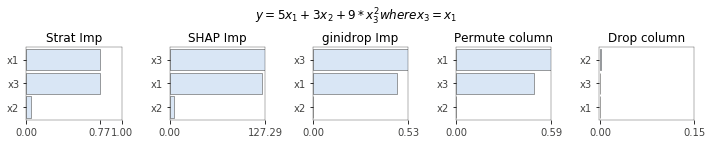

In [140]:
compare_imp(rf,X,y,eqn)

## Synthetic degree 2 polynomial with sine

In [141]:
def synthetic_poly2_sine_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    df['y'] = 5*df['x1'] + 15*np.sin(df['x2']+(n/2)*(2*np.pi)/n) - df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 + 15 sin(x_2) - x_3^2"

In [142]:
df, coeff, eqn = synthetic_poly2_sine_data(500,3)
df.head()

,x1,x2,x3,y
0,1.4,4.5,3.0,12.662952
1,5.7,7.8,5.8,-20.118150
2,2.0,5.4,2.3,16.301467
3,6.2,7.5,8.5,-55.320000
4,2.0,0.3,2.8,-2.272803


In [143]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

x1 mass 22.217042845337783
min,max pdpy -7.678878994066626 35.11900127285336
x2 mass 8.628223935114853
min,max pdpy -8.713231258651135 11.801124553767774
x3 mass 62.80550859354688
min,max pdpy -87.88217410393807 5.998563956269902
Avgs [22.21704285  8.62822394 62.80550859] sum avgs 93.65077537399952
### remaining mass % -3.257645115910639
normalized avgs [0.24496108 0.09513323 0.69248214] ratios 2.5749265448384593
mean abs y 28.071308697114276
y_mass = mean abs min-clipped 90.69621456975216
mean abs mean-centered 27.875297898749565
[11.14717299  5.22808307 24.76596101]


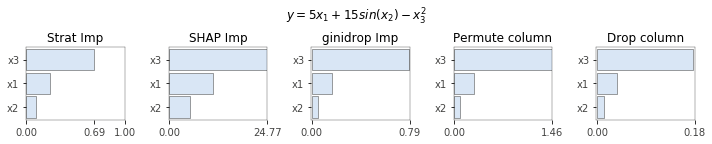

In [144]:
compare_imp(rf,X,y,eqn)

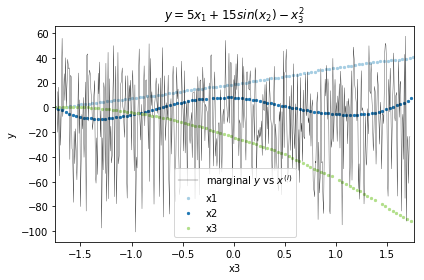

In [145]:
plot_all_PD(X,y,eqn)

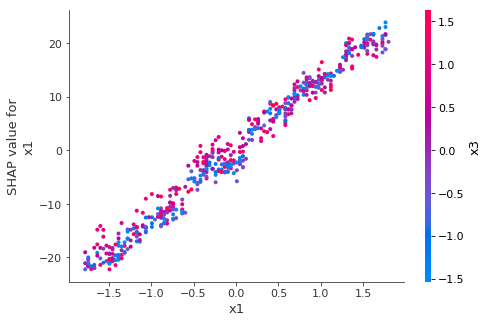

In [146]:
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.dependence_plot("x1", shap_values, X)

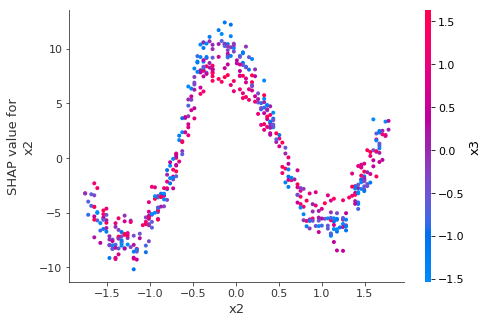

In [147]:
shap.dependence_plot("x2", shap_values, X)

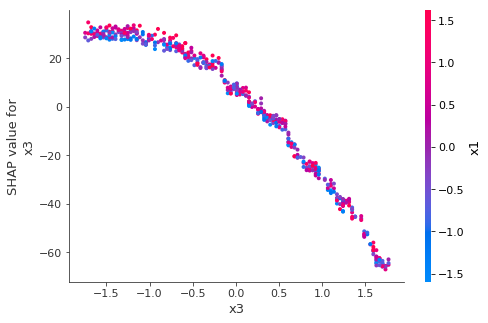

In [148]:
shap.dependence_plot("x3", shap_values, X)

## Toy weight data

In [149]:
def toy_weight_data(n):
    df = pd.DataFrame()
    nmen = n // 2
    nwomen = n // 2
    df['sex'] = ['M'] * nmen + ['F'] * nwomen
    df.loc[df['sex'] == 'F', 'pregnant'] = np.random.randint(0, 2, size=(nwomen,))
    df.loc[df['sex'] == 'M', 'pregnant'] = 0
    df.loc[df['sex'] == 'M', 'height'] = 5 * 12 + 8 + np.random.uniform(-7, +8,
                                                                        size=(nmen,))
    df.loc[df['sex'] == 'F', 'height'] = 5 * 12 + 5 + np.random.uniform(-4.5, +5,
                                                                        size=(nwomen,))
    df.loc[df['sex'] == 'M', 'education'] = 10 + np.random.randint(0, 8, size=nmen)
    df.loc[df['sex'] == 'F', 'education'] = 12 + np.random.randint(0, 8, size=nwomen)
    df['weight'] = 120 \
                   + (df['height'] - df['height'].min()) * 10 \
                   + df['pregnant'] * 30 \
                   - df['education'] * 1.5
    df['pregnant'] = df['pregnant'].astype(bool)
    df['education'] = df['education'].astype(int)
    return df

In [150]:
df = toy_weight_data(100)
df.head()

,sex,pregnant,height,education,weight
0,M,False,65.818002,13,150.991170
1,M,False,62.292138,15,112.732534
2,M,False,63.678095,16,125.092102
3,M,False,73.637512,17,223.186274
4,M,False,72.684866,14,218.159811


In [151]:
X = df.drop('weight', axis=1)
y = df['weight']
X['sex'] = X['sex'].map({'M':0, 'F':1})
#X = featimp.standardize(X)
X.head()

,sex,pregnant,height,education
0,0,False,65.818002,13
1,0,False,62.292138,15
2,0,False,63.678095,16
3,0,False,73.637512,17
4,0,False,72.684866,14


sex mass 0.0
min,max pdpy 0.0 0.0
pregnant mass 0.0
min,max pdpy 0.0 0.0
height mass 60.35138735535036
min,max pdpy 0.0 150.3573040208009
education mass 14.8590254136823
min,max pdpy -23.619335272123763 0.0
Avgs [ 0.          0.         60.35138736 14.85902541] sum avgs 75.21041276903266
### remaining mass % 1.9109719731092931
normalized avgs [0.         0.         0.78709965 0.19379063] ratios nan
mean abs y 168.1756632030384
y_mass = mean abs min-clipped 76.6756632030384
mean abs mean-centered 31.05251175355279


/Users/parrt/anaconda3/lib/python3.7/site-packages/stratx-0.2-py3.7.egg/stratx/featimp.py:55: RuntimeWarning: invalid value encountered in double_scalars
  print("normalized avgs", avgs, 'ratios', avgs[0]/avgs[1])


[ 0.16920129  7.9339119  29.3469011   0.74309259]


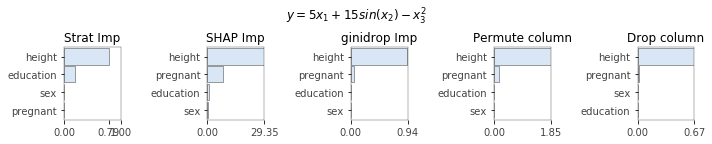

In [152]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)
compare_imp(rf,X,y,eqn)

# Playground

(-2, 2)

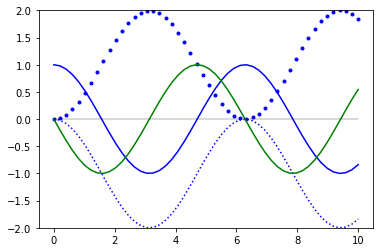

In [153]:
x = np.linspace(0,10)
y = np.cos(x)
y_ = -np.sin(x)

plt.plot(x,y, c='blue')
plt.plot(x,y-y[0], ':', c='blue')
plt.plot(x,np.abs(y-y[0]), '.', c='blue')
plt.plot(x,y_, c='green')
# plt.plot(x,np.abs(y_), ':', c='green')
plt.plot([0,10], [0,0], c='k', lw=.3)
plt.ylim(-2,2)

[<matplotlib.lines.Line2D at 0x1c1a6d9048>]

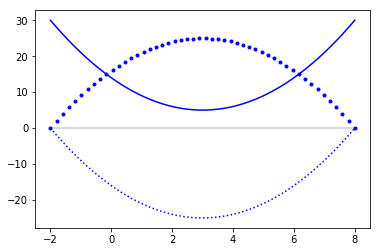

In [154]:
x = np.linspace(-2,8)
y = (x-3)**2+5
plt.plot(x,y, c='blue')
plt.plot(x,y-y[0], ':', c='blue')
plt.plot(x,np.abs(y-y[0]), '.', c='blue')
plt.plot([-2,8], [0,0], c='k', lw=.3)

[<matplotlib.lines.Line2D at 0x1c1a228f98>]

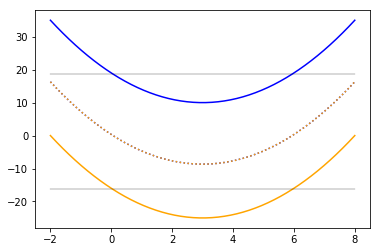

In [155]:
x = np.linspace(-2,8)
y = (x-3)**2+10
y_ = (x-3)**2
#shift = np.mean(y) - np.mean(y_)
plt.plot(x,y, c='blue')
plt.plot(x,y-np.mean(y), ':', c='blue')
plt.plot(x,y-y[0], c='orange')
plt.plot(x,y-y[0]-np.mean(y-y[0]), ':', c='orange')
# plt.plot(x,y_-np.mean(y_), ':', c='orange')
plt.plot([-2,8], [np.mean(y),np.mean(y)], c='k', lw=.3)
plt.plot([-2,8], [np.mean(y-y[0]),np.mean(y-y[0])], c='k', lw=.3)

In [156]:
np.mean(y), np.mean(y_), np.mean(y) - np.mean(y_), y[0]

(18.673469387755105, 8.673469387755103, 10.000000000000002, 35.0)

In [157]:
# ok so subtract mean of y and PD of y then measure/compare area under curve